## **Introduction**
The goal of this project is to to use the close price to predict the next day price. I will use the LSTM (Long Short Term memory) and ARIMA models to predict the next day price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from textblob import TextBlob 
from wordcloud import WordCloud 

import warnings
warnings.filterwarnings('ignore')

Using Theano backend.


### **Adjusted Closing Price**
The closing price of a stock is the price of that stock at the close of the trading day. The adjusted closing price uses the closing price as a starting point, but it also takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.<br>

In [2]:
"""
Pfizer(PFE)   $51.75 billion.
Roche(RO)    $50 billion.
Novartis(NOVN) $47.45 billion.
Merck(MRK)    $46.84 billion.
GlaxoSmithKline(GSK) $43.54 billion.
Johnson & Johnson(JNJ) $42.1 billion.

Moderna (MRNA)
Novavax (NVAX)
"""
def get_data_plot(ticker, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("Stock Adjusted Price Historical Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2018-01-02,30.589575,128.347687,26.000000,NaN,31.993856
2018-01-03,30.816229,129.573715,27.000000,NaN,32.057152
2018-01-04,30.883387,129.564484,26.400000,NaN,32.102367
2018-01-05,30.942144,130.633850,25.799999,NaN,32.436958
2018-01-08,30.597971,130.799789,27.000000,NaN,32.210884
...,...,...,...,...,...
2020-12-24,36.868916,152.470001,129.339996,123.389999,48.520000
2020-12-28,36.423756,153.190002,116.849998,111.400002,49.380001
2020-12-29,36.651279,154.139999,120.269997,114.389999,49.900002


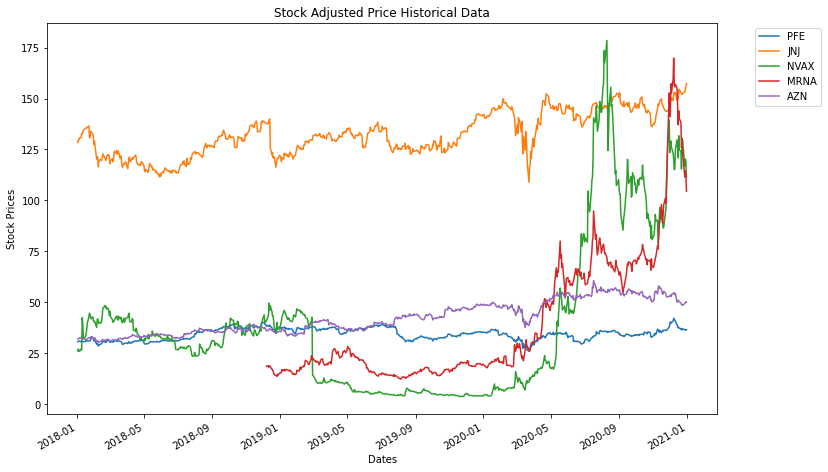

In [3]:
df_1 = get_data_plot([['PFE','JNJ','NVAX','MRNA','AZN']], plot=True, start='2018',end='2021',stock_value='Adj Close')
df_1

## 2  Daily Price Change

In [4]:
def diff_data_plot(ticker, plot=True):
 
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo','2018','2021')['Adj Close']
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1_diff = df_1.diff()
            df_1_diff.plot(figsize=(12,8))
            plt.title("Historical Stock Price Change")
            #plt.set(title=f'Housing Prices by Year - {zip_df.index.freq}')
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices USD ($)')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1_diff
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'
            

<function __main__.diff_data_plot(ticker, plot=True)>

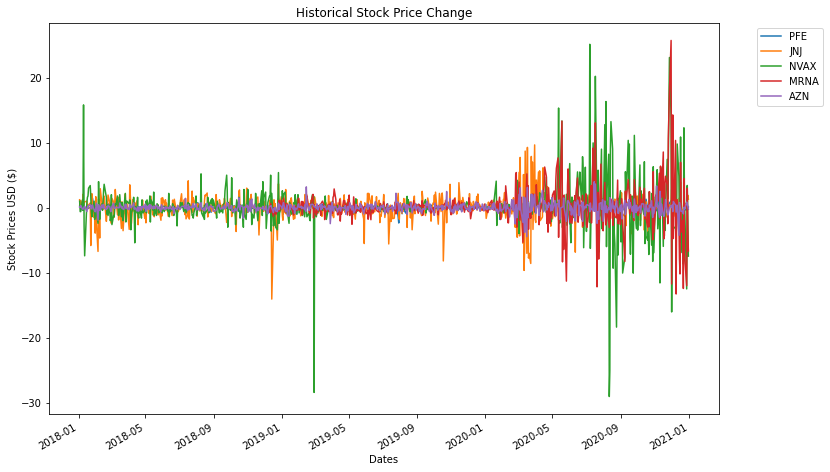

In [5]:
diff_data_plot([['PFE','JNJ','NVAX','MRNA','AZN']], plot=True)
diff_data_plot

## Twitter/Sentiment Analysis
Below are the twitter feeds regarding the pharmaceutical companies and corresponding sentiment analysis of the feeds.<br>

In [6]:
import json
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 

In [7]:
with open('/Users/davidtorres/.secret/config_Mod_5.json') as file:
    json_data = json.load(file)

In [8]:
authenticate = tweepy.OAuthHandler(json_data['consumer_key'],json_data['consumer_secret_key'])
authenticate.set_access_token(json_data['access_token'], json_data['access_token_secret'])

In [9]:
api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
#api = tweepy.API(authenticate, wait_on_rate_limit= True)
posts = api.user_timeline(screen_name='@JNJNEWS', count=20, lang='en', tweet_mode='extended')
#tweets = api.user_timeline(screen_name='whoever', count=5, tweet_mode='extended')


In [10]:
def get_tweets(posts):
    tweet_list = []
    for twt in posts:
        tweet_list.append(twt._json)
    tweet_data = pd.DataFrame.from_records(tweet_list)#tweet_df = tweet_data[['created_at','full_text']]
    tweet_df = tweet_data[['created_at','full_text']]
    tweet_df['Date'] = pd.to_datetime(tweet_df['created_at'])
    tweet_df['Date'] = pd.to_datetime(tweet_df['Date'], format='%Y:%m:%d').dt.date
    tweet_df.set_index(["Date"], inplace = True) 
    tweet_df.drop('created_at',axis=1,inplace=True)
    return tweet_df

In [11]:
tweets_df = get_tweets(posts)
tweets_df

,full_text
Date,
2021-01-30,Interested in learning more about our investig...
2021-01-29,"@DeniseDorey Hello Denise, thanks for sharing!..."
2021-01-29,"Alex Gorsky, Chairman &amp; CEO, #JNJ, reflect..."
2021-01-29,JUST IN: Topline interim data analysis from ou...
2021-01-28,Johnson &amp; Johnson joins @wef’s Partnering ...
2021-01-28,"@jillxo320 Thanks for your question, Jill. The..."
2021-01-28,"@AHammer16 Hello Alex, we're happy to confirm ..."
2021-01-28,@_windsorgrace @_windsorgrace Thank you for co...
2021-01-27,Our longstanding commitment has helped make #a...


In [12]:
#clean the text
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+','',text) #r-tells python that expression is a raw tring, once we find substitute fo empty string
  #get rid of any hashtag or number sign
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+','', text)  #retweets followed by 1 or more white spaces
    #remove the hyper link
    text = re.sub(r'https?:\/\/\S+','', text)      #may have 0 or 1 s character
    
    return text

In [13]:
#cleaning hte text
tweets_df['full_text'] = tweets_df['full_text'].apply(cleanTxt)

In [14]:
tweets_df

,full_text
Date,
2021-01-30,Interested in learning more about our investig...
2021-01-29,"Hello Denise, thanks for sharing! Please give..."
2021-01-29,"Alex Gorsky, Chairman &amp; CEO, JNJ, reflects..."
2021-01-29,JUST IN: Topline interim data analysis from ou...
2021-01-28,Johnson &amp; Johnson joins ’s Partnering for ...
2021-01-28,"Thanks for your question, Jill. There were va..."
2021-01-28,"Hello Alex, we're happy to confirm that Zonas..."
2021-01-28,@_windsorgrace @_windsorgrace Thank you for co...
2021-01-27,Our longstanding commitment has helped make ac...


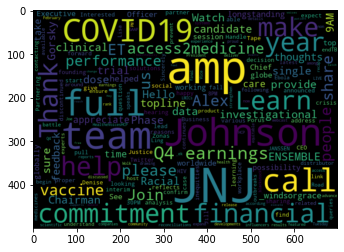

In [15]:
allWords = ' '.join([twts for twts in tweets_df['full_text']])
wordCloud = WordCloud(width=700, height=500, random_state=21,max_font_size=110).generate(allWords)
plt.imshow(wordCloud,interpolation='bilinear')

In [16]:
#get subjectivity (how subjective or opinated text is)and pularity (how postive or negative text is)
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [17]:
#create 2 new columns
tweets_df['Subjectivity'] = tweets_df['full_text'].apply(getSubjectivity)
tweets_df['Polarity'] = tweets_df['full_text'].apply(getPolarity)

In [18]:
def getAnalysis(score):
    #function to calculate the negative, neutral and positve analysis
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [19]:
#polarity is the score and going to apply the  function
tweets_df['Analysis'] = tweets_df['Polarity'].apply(getAnalysis)

In [20]:
tweets_df.head()

,full_text,Subjectivity,Polarity,Analysis
Date,,,,
2021-01-30,Interested in learning more about our investig...,0.500000,0.375000,Positive
2021-01-29,"Hello Denise, thanks for sharing! Please give...",0.200000,0.250000,Positive
2021-01-29,"Alex Gorsky, Chairman &amp; CEO, JNJ, reflects...",0.000000,0.000000,Neutral
2021-01-29,JUST IN: Topline interim data analysis from ou...,0.000000,0.000000,Neutral
2021-01-28,Johnson &amp; Johnson joins ’s Partnering for ...,0.283333,0.266667,Positive


## Technical Indicators for Quantative Trading
1. Simple Moving Average
2. Average True Range

### Simple Moving Average
Simple Moving Average is one of the most common technical indicators.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock.<br>
The most commonly used moving averages are the 5-day, 10-day, 20-day, 50-day, and the 200-day moving averages.<br>
SMA takes hte prcie of stock over a certain number of periods and averages the price together. This is useful when trying to identify trends. Sometimres we can identify these trend changes when the SMA closing price drops over.  What this means for a ninvestor is that the closing price differes greatly frm the simple moving averageso it may be time to buy or sell as stock.<br>

,Adj Close
Date,
2019-01-02,62.023998
2019-01-03,60.071999
2019-01-04,63.537998
2019-01-07,66.991997
2019-01-08,67.070000
...,...
2020-12-24,661.770020
2020-12-28,663.690002
2020-12-29,665.989990


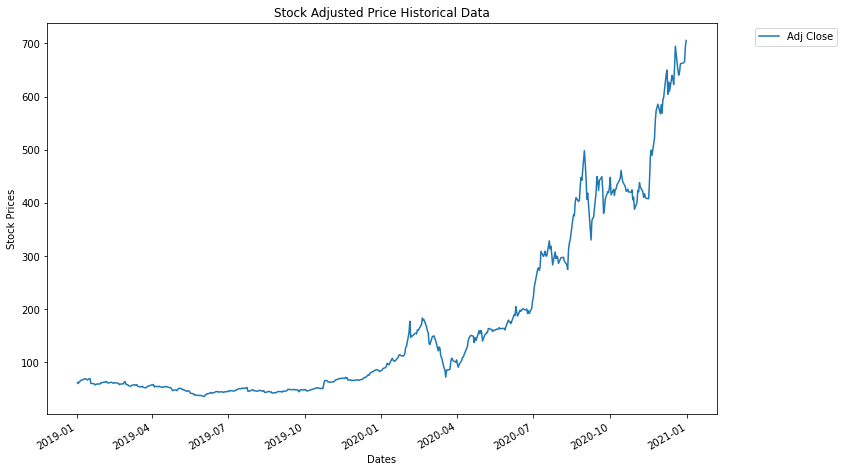

In [94]:
df_sma = get_data_plot(['TSLA'], plot=True, start='2019',end='2021',stock_value='Adj Close')
df_sma

In [95]:
"""
program uses the 3 moving averages crossoever stategy to determine when to buy and sell stock. 
calculate 3 moving averages
"""
#short or fast exponential moving average
shortEMA = df_sma['Adj Close'].ewm(span=5, adjust=False).mean()
#calcualte middle/medium exponential moving average
middleEMA = df_sma['Adj Close'].ewm(span=21, adjust=False).mean()
#calculte long/slow exponential moving average
longEMA= df_sma['Adj Close'].ewm(span=63, adjust=False).mean()

In [96]:
#visualize adj closing pprice and exponential moving averages

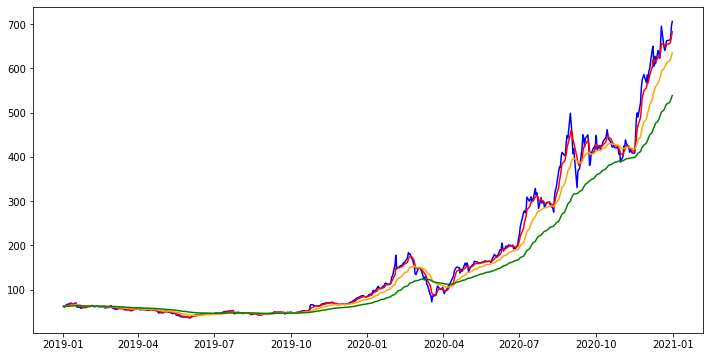

In [97]:
"""
concerned w/crossing of exponential averages
this strategy tells us when to buy and when to sell the stock
"""
plt.figure(figsize=(12,6))
plt.plot(df_sma['Adj Close'],label='Adj Close',color='blue')
plt.plot(shortEMA, label='Short/Fast',color='red')
plt.plot(middleEMA,label='Middle',color='orange')
plt.plot(longEMA,label='Long/slow',color='green')


In [98]:
#calculate when to buy and sell
#add exponential moving averages to teh data set
df_sma['Short'] = shortEMA
df_sma['Middle'] = middleEMA
df_sma['Long'] = longEMA

In [99]:
df_sma.head()

,Adj Close,Short,Middle,Long
Date,,,,
2019-01-02,62.023998,62.023998,62.023998,62.023998
2019-01-03,60.071999,61.373332,61.846544,61.962998
2019-01-04,63.537998,62.094887,62.000312,62.012217
2019-01-07,66.991997,63.727257,62.454102,62.167835
2019-01-08,67.070000,64.841505,62.873729,62.321028


In [100]:
#create the function buy and sell stock
def buy_sell_stock(data):
    buy_list = []
    sell_list = []
    flag_long=False  #flags tell which portion of stratgy I'm in
    flag_short=False
    
    for i in range(0,len(data)): #loop through and find all times that strategy applies
        #when to buy stock
        if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_short = True
        #when to sell stock
        elif flag_short == True and data['Short'][i] > data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_short = False  
                                 
        elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_long = True
        #when to sell stock
        elif flag_long == True and data['Short'][i] < data['Middle'][i]:
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_long = False  
        else:
            buy_list.append(np.nan) 
            sell_list.append(np.nan) 
    return (buy_list,sell_list)                             

In [101]:
#add buy and sell signals to dataset
df_sma['Buy'] = buy_sell_stock(df_sma)[0]
df_sma['Sell'] = buy_sell_stock(df_sma)[1] #return index1

In [102]:
df_sma.head()

,Adj Close,Short,Middle,Long,Buy,Sell
Date,,,,,,
2019-01-02,62.023998,62.023998,62.023998,62.023998,NaN,NaN
2019-01-03,60.071999,61.373332,61.846544,61.962998,60.071999,NaN
2019-01-04,63.537998,62.094887,62.000312,62.012217,NaN,63.537998
2019-01-07,66.991997,63.727257,62.454102,62.167835,66.991997,NaN
2019-01-08,67.070000,64.841505,62.873729,62.321028,NaN,NaN


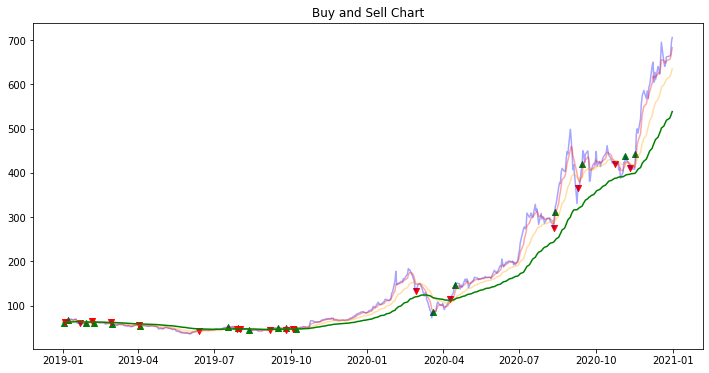

In [103]:
#visaully show stock buy and sell signals
plt.figure(figsize=(12,6))
plt.title('Buy and Sell Chart')
plt.plot(df_sma['Adj Close'],label='Adj Close',color='blue',alpha=0.35)
plt.plot(shortEMA, label='Short/Fast',color='red',alpha=0.35)
plt.plot(middleEMA,label='Middle',color='orange',alpha=0.35)
plt.plot(longEMA,label='Long/slow',color='green')
plt.scatter(df_sma.index,df_sma['Buy'],color='green',marker='^',alpha=1) #show momentum stock going up
plt.scatter(df_sma.index,df_sma['Sell'],color='red',marker='v',alpha=1) #show momentum stock going up


## **Forecasting**
### Long Short Term Memory (LSTM)

In [21]:
def get_data(symbol, data_source,start,end):
    df = web.DataReader(symbol,data_source, start, end) 
    #print('Dataset consisits of {} and {}'.format(df[0].shape,df[1].shape))
    df_shape = df.shape
    print('Dataframe consists of {} rows and {} columns'.format(df_shape[0],df_shape[1]))
    
    plt.figure(figsize=(12,8))
    plt.plot(df['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    return df

Dataframe consists of 527 rows and 6 columns


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-07,22.750000,18.510000,22.000000,18.600000,12995600,18.600000
2018-12-10,19.438999,18.000000,18.900000,18.799999,4233300,18.799999
2018-12-11,20.660000,17.990000,20.549999,18.010000,3435300,18.010000
2018-12-12,19.480000,18.020000,18.549999,18.680000,2590700,18.680000
2018-12-13,19.290001,18.680000,19.250000,18.760000,1608600,18.760000
...,...,...,...,...,...,...
2021-01-05,114.980003,107.199997,113.820000,109.180000,15450800,109.180000
2021-01-06,116.930000,110.279999,111.110001,116.260002,21590900,116.260002
2021-01-07,122.820000,112.129997,120.099998,115.089996,20614100,115.089996


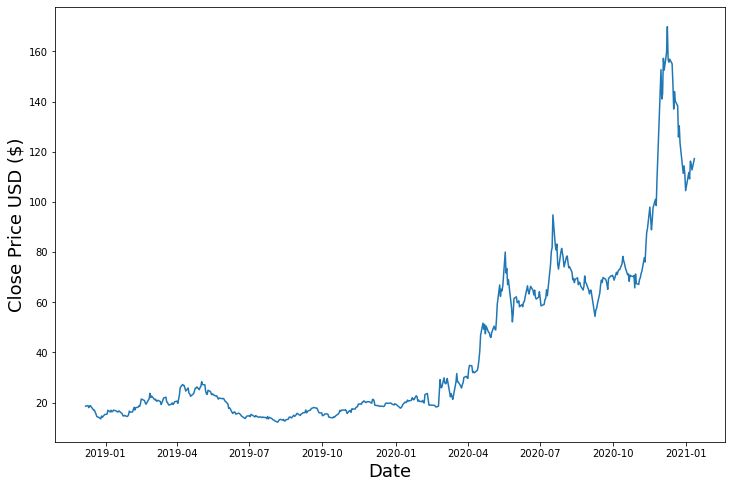

In [22]:
the_data = get_data('MRNA',data_source='yahoo', start='2016-01-01',end='2021-1-11')
the_data

In [23]:
diff_df = the_data.copy()

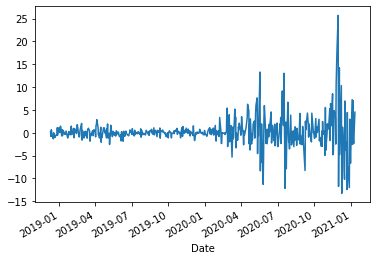

In [24]:
#change in price for day
#radio button or drop down
the_data.diff()['Adj Close'].plot()

In [25]:
diff_df['Prct_Change'] = the_data.diff().dropna()['Adj Close']

In [26]:
diff_df.head()

,High,Low,Open,Close,Volume,Adj Close,Prct_Change
Date,,,,,,,
2018-12-07,22.750000,18.51,22.000000,18.600000,12995600,18.600000,NaN
2018-12-10,19.438999,18.00,18.900000,18.799999,4233300,18.799999,0.199999
2018-12-11,20.660000,17.99,20.549999,18.010000,3435300,18.010000,-0.789999
2018-12-12,19.480000,18.02,18.549999,18.680000,2590700,18.680000,0.670000
2018-12-13,19.290001,18.68,19.250000,18.760000,1608600,18.760000,0.080000


In [27]:
#df = pd.read_csv('data/apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

#Get the stock quote 
#df = web.DataReader('TGT', data_source='yahoo', start='2016-01-01', end='2021-1-11') 

In [28]:
#df = df.diff().dropna() #zip_df[11226].diff().dropna()

In [29]:
def preprocessing(df,percentage):
    training_data_len = int(np.round(len(df) * percentage))
    dataset = pd.DataFrame(df)
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_data = scaler.fit_transform(dataset)
    return training_data_len, dataset, scaler, scaled_data

In [30]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df['Close'], percentage=.8)
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data['Adj Close'], percentage=.8)

In [31]:
def create_sets(training_data_len):
    #create training data set
    train_data = scaled_data[0:training_data_len,:]
    test_data = scaled_data[training_data_len -60:,:] #to 2003 which is end of dataset
    #split data into X_train and y_train data sets
    X_train = []
    y_train = []
    #create dataset X_test and y_test data sets
    X_test = []
    y_test = []    #dataset.iloc[training_data_len:, :]


    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i])
        y_train.append(train_data[i,0]) #will contain 61st value which will be at position 60

    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i,0]) 
        y_test.append(test_data[i,0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)  
    X_test = np.array(X_test) #added
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) #added
    y_test = np.array(y_test)
        
    return X_train, X_test, y_train, y_test    

In [32]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [33]:
#early_stop = EarlyStopping(monitor='val_loss', patience=2)

def create_model(X_train, y_train):
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 25))
    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.summary()
    
    return model


In [34]:

model = create_model(X_train,y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [35]:
#callbacks=[early_stop]
early_stop = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop])     

Epoch 1/10
362/362 [==============================] - 5s 13ms/step - loss: 0.0090
Epoch 2/10
362/362 [==============================] - 4s 11ms/step - loss: 0.0023
Epoch 3/10
362/362 [==============================] - 2s 5ms/step - loss: 0.0019
Epoch 4/10
362/362 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 5/10
362/362 [==============================] - 1s 4ms/step - loss: 0.0013
Epoch 6/10
362/362 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 7/10
362/362 [==============================] - 2s 6ms/step - loss: 0.0013
Epoch 8/10
362/362 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 9/10
362/362 [==============================] - 2s 5ms/step - loss: 0.0013
Epoch 10/10
362/362 [==============================] - 2s 5ms/step - loss: 0.0013


In [36]:
def save_model():
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [37]:
model_params = save_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [38]:
def make_prediction(model, X_test, y_test,training_data_len):
    predictions = model.predict(X_test)
    prediction_unscaled = scaler.inverse_transform(predictions) #unscaling the values
    
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1,1)) #unscaling the values
    
    #this is in dollars
    rmse_predictions = np.sqrt(np.mean(prediction_unscaled -y_test_unscaled)**2)
    rmse_predictions
    
    predictions = pd.DataFrame(prediction_unscaled, columns=['Predictions'])
    
    train = dataset[:training_data_len]
    valid = dataset[training_data_len:] #data from index training_data_len to 
    
    valid.reset_index(inplace=True)
    valid['Prediction'] = predictions['Predictions']
    valid1 = valid.set_index('Date')
    
    plt.figure(figsize=(12,8))
    plt.title('Model')
    plt.xlabel('Label')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train['Adj Close'])
    #plt.plot(valid[['Close','Predictions']])
    plt.plot(valid1['Adj Close'])
    plt.plot(valid1['Prediction'])
    # #valid[['Close','Predictions']].plot()
    plt.legend(['Train','Valid','Predictions'],loc='lower right')
    return rmse_predictions, valid1
    

(6.3564341953822545,
              Adj Close  Prediction
 Date                              
 2020-08-12   69.519997   77.051559
 2020-08-13   67.830002   76.475822
 2020-08-14   69.150002   75.802887
 2020-08-17   69.760002   75.086082
 2020-08-18   67.029999   74.376846
 ...                ...         ...
 2021-01-05  109.180000  117.436005
 2021-01-06  116.260002  115.148186
 2021-01-07  115.089996  113.119766
 2021-01-08  112.750000  111.395950
 2021-01-11  117.260002  109.943779
 
 [105 rows x 2 columns])

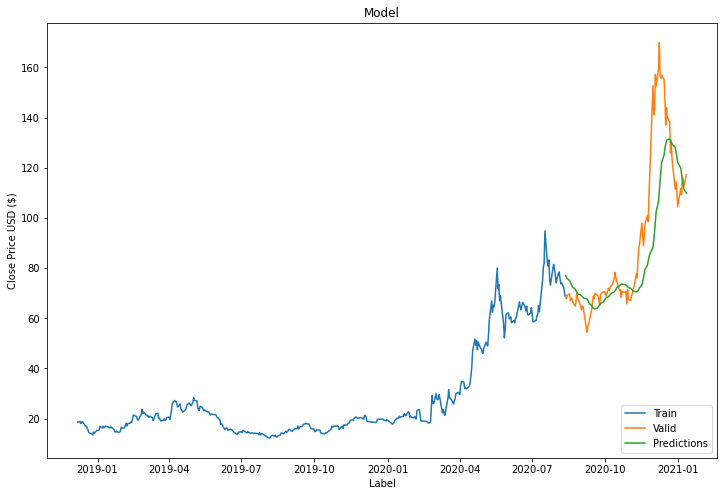

In [39]:
make_prediction(model, X_test,y_test, training_data_len )

In [40]:
from sklearn import metrics

In [41]:
"""
blue-data model was trainined on 
orange-actual closing stock price for rest of days
green-what model predcited values to be

predict closing price fo TGT stock for 2021-1-11  199.10

get the quote
"""
def get_quote(new_df):
    #get last 60days closing values and convert datframe to an array
    last_60_days = new_df[-60:].values #converts to array
    #scale data
    last_60_days_scaled = scaler.transform(last_60_days)
    #create empty list
    x_test = []
    #append last 60 days to x_test
    x_test.append(last_60_days_scaled)
    #conert x_test to a numpy array
    x_test = np.array(x_test)
    # #reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #get the predicted scaled price
    pred_price = model.predict(x_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price) 
    #what model thinks predicted price will be for 12/18/2019
    #the actual prcie was $69.94
    #DAL: 58.58, 2021-1-11 40.19
    return pred_price                    

In [42]:
get_quote(dataset)

array([[108.80437]], dtype=float32)

## New Model

Dataframe consists of 1265 rows and 6 columns


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990
2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978
2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024
2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002
2016-01-08,624.140015,606.000000,619.659973,607.049988,5512900,607.049988
...,...,...,...,...,...,...
2021-01-05,3223.379883,3165.060059,3166.010010,3218.510010,2655500,3218.510010
2021-01-06,3197.510010,3131.159912,3146.479980,3138.379883,4394800,3138.379883
2021-01-07,3208.540039,3155.000000,3157.000000,3162.159912,3514500,3162.159912


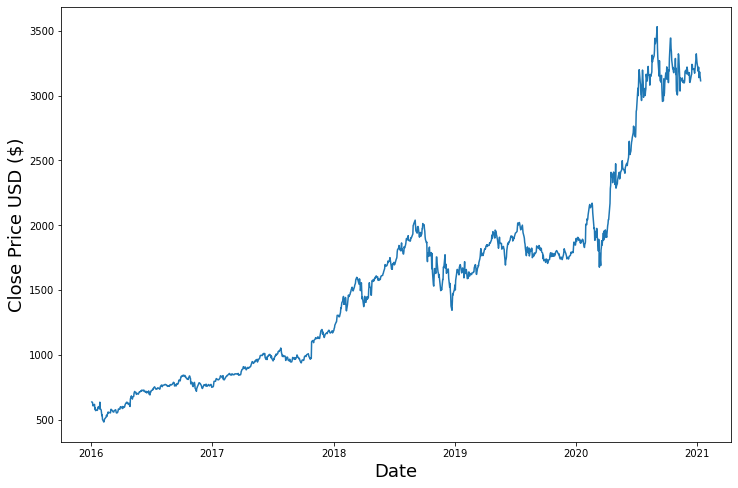

In [43]:
the_data = get_data('AMZN',data_source='yahoo', start='2016-01-01',end='2021-1-11')
the_data

In [44]:
training_data_len, dataset, scaler, scaled_data = preprocessing(the_data['Adj Close'], percentage=.8)

In [45]:
X_train, X_test, y_train, y_test = create_sets(training_data_len)

In [46]:
model_params.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [47]:
#model.fit(X_train,y_train, epochs=50,batch_size=32,callbacks=[early_stop])  

(282.8675648082386,
               Adj Close   Prediction
 Date                                
 2020-01-10  1883.160034  1826.306274
 2020-01-13  1891.300049  1833.092529
 2020-01-14  1869.439941  1839.012695
 2020-01-15  1862.020020  1843.719482
 2020-01-16  1877.939941  1847.063232
 ...                 ...          ...
 2021-01-05  3218.510010  2810.221191
 2021-01-06  3138.379883  2813.394775
 2021-01-07  3162.159912  2814.249023
 2021-01-08  3182.699951  2813.185791
 2021-01-11  3114.209961  2810.996338
 
 [253 rows x 2 columns])

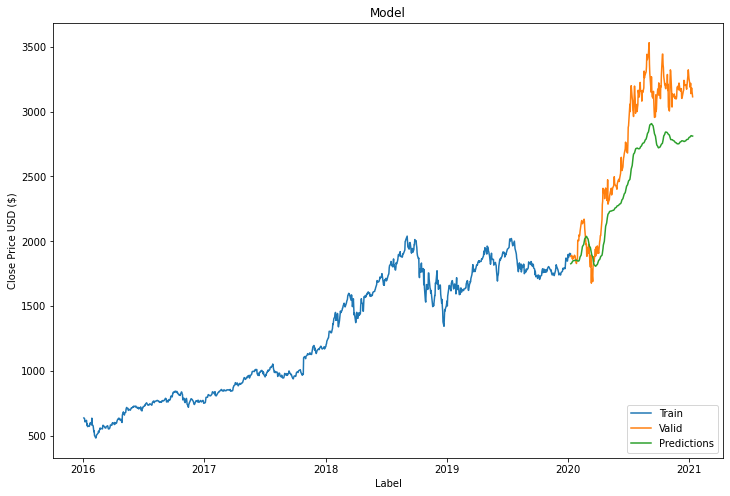

In [48]:
make_prediction(model_params, X_test,y_test, training_data_len )

In [49]:
get_quote(dataset)

array([[2807.233]], dtype=float32)

## SARIMA MODEL
A time series is a sequence where we record a metric over regular intervals.  Forecasting is the future value that this sequence will take.<br>
An ARIMA model is a forecasting algorithm that takes in previous past values to predict future values.  ARIMA models use past performance to predict future performance.  Based on its own lag and lag errors.  A SARIMA model is an ARIMA model with a seasonality component.<br>

In [50]:
"""
ARIMA is a forecasting model based on idea that information of past values may be indicative of future values.
ARIMA explains a ts based on its own past values, basically its own lags and lagged forecast errors.
"""
the_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990
2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978
2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024
2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002
2016-01-08,624.140015,606.000000,619.659973,607.049988,5512900,607.049988


In [51]:
df_data = the_data['Adj Close']
df_data = pd.DataFrame(df_data)

In [52]:
df_data.head()

,Adj Close
Date,
2016-01-04,636.989990
2016-01-05,633.789978
2016-01-06,632.650024
2016-01-07,607.940002
2016-01-08,607.049988


In [53]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1265 entries, 2016-01-04 to 2021-01-11
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1265 non-null   float64
dtypes: float64(1)
memory usage: 19.8 KB


## Train Test Split

In [54]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
n = int(len(df_data) * 0.8)
train = df_data[:n]
test = df_data[n:]

In [55]:
#1265
len(train), len(test)

(1012, 253)

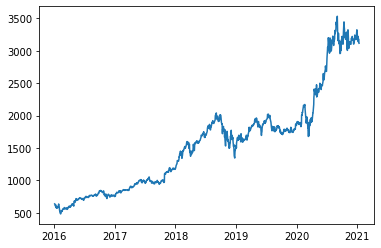

In [56]:
plt.plot(df_data.index, df_data["Adj Close"])

In [57]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [58]:
"""
Need to find optimal parameters so you can fit ARIMA model.
Forecasting using optimal parameters
"""
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [59]:
train.shape 

(1012, 1)

In [60]:
stepwise_fit = arima_model(train['Adj Close'])

In [61]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1012
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood               -4616.534
Date:                              Sat, 30 Jan 2021   AIC                           9245.068
Time:                                      10:08:00   BIC                           9274.515
Sample:                                           0   HQIC                          9256.260
                                             - 1012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1768      0.092      1.912      0.056      -0.004       0.358
ar.L1          0.9899      0.005    209.141      0.000       0.981       0.999
ar.S.L12       0.0218      0.018      1.220      0.222      -0.013       0.057
ar.S.L24      -0.0458      0.022     -2.082      0.037      -0.089      -0.003
ma.S.L12      -1.0000      0.025    -39.879      0.000      -1.049      -0.951
sigma2       567.4349   4.42e-05   1.28e+07      0.000     567.435     567.435
===================================================================================
Ljung-Box (Q):                       55.77   Jarque-Bera (JB):              1394.26
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               9.25   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.1e+22. Standard errors may be unstable.
"""

In [62]:
arima_list = [['zipcode', 'pdq','seasonal_pdq','aic']] 
for col in df_data.columns:
  zip_test_2 = arima_model(df_data[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

,zipcode,pdq,seasonal_pdq,aic
0,Adj Close,"(3, 0, 3)","(2, 1, 2, 12)",12536.070809


In [63]:
import statsmodels.api as sm

In [64]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [65]:
train['Adj Close'][[0,-1]]

Date
2016-01-04     636.989990
2020-01-09    1901.050049
Name: Adj Close, dtype: float64

In [66]:
test['Adj Close'][[0,-1]]

Date
2020-01-10    1883.160034
2021-01-11    3114.209961
Name: Adj Close, dtype: float64

In [67]:
test

,Adj Close
Date,
2020-01-10,1883.160034
2020-01-13,1891.300049
2020-01-14,1869.439941
2020-01-15,1862.020020
2020-01-16,1877.939941
...,...
2021-01-05,3218.510010
2021-01-06,3138.379883
2021-01-07,3162.159912


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               Adj Close   No. Observations:                 1265
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -6213.692
Date:                                 Sat, 30 Jan 2021   AIC                          12449.385
Time:                                         10:19:01   BIC                          12505.602
Sample:                                              0   HQIC                         12470.540
                                                - 1265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0845      0.375      2.894      0.004       0.350       1.819
ar.L2          0.2932      0.297      0.987      0.323      -0.289       0.875
ar.L3         -0.3791      0.326     -1.163      0.245      -1.018       0.260
ma.L1         -0.1776      0.374     -0.475      0.635      -0.911       0.555
ma.L2         -0.2872      0.305     -0.942      0.346      -0.885       0.311
ma.L3         -0.0736      0.039     -1.888      0.059      -0.150       0.003
ar.S.L12      -0.5963      0.196     -3.048      0.002      -0.980      -0.213
ar.S.L24      -0.0906      0.042     -2.166      0.030      -0.173      -0.009
ma.S.L12      -0.3215      0.196     -1.640      0.101      -0.706       0.063
ma.S.L24      -0.5842      0.193     -3.021      0.003      -0.963      -0.205
sigma2      2274.0173     81.372     27.946      0.000    2114.531    2433.503
===================================================================================
Ljung-Box (Q):                       86.38   Jarque-Bera (JB):              1844.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.47   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


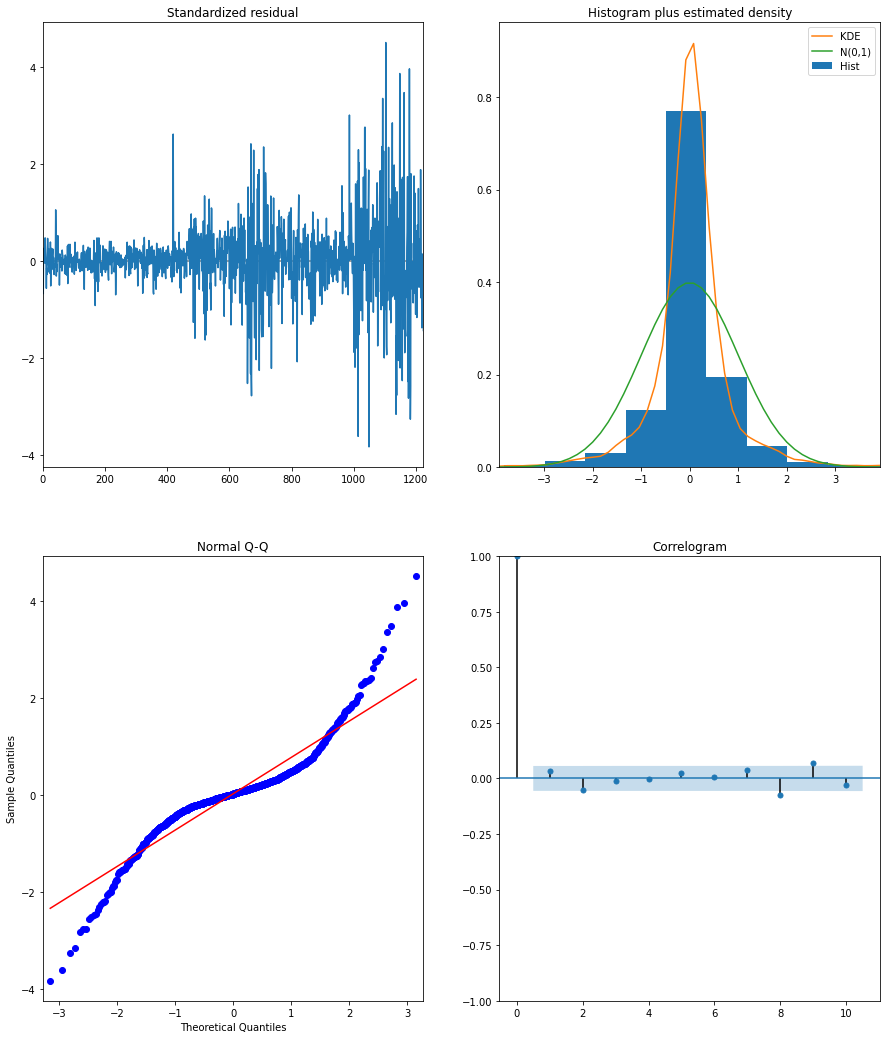

In [68]:
current_zip = 'Adj Close'
zip_params= output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0], seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

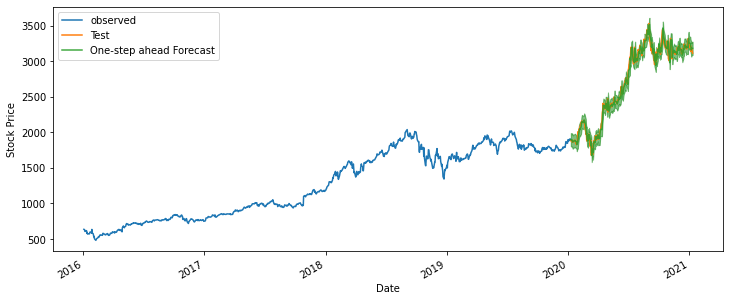

In [69]:
plt.figure(figsize=(12,5))
# Plot observed values
ax = train['Adj Close'].plot(label='observed')
test['Adj Close'].plot(label='Test')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
plt.legend()

In [70]:
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 3840.46
The Root Mean Squared Error of our forecasts is 61.97


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                               Adj Close   No. Observations:                 1265
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood               -6213.692
Date:                                 Sat, 30 Jan 2021   AIC                          12449.385
Time:                                         10:20:04   BIC                          12505.602
Sample:                                              0   HQIC                         12470.540
                                                - 1265                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0845      0.375      2.894      0.004       0.350       1.819
ar.L2          0.2932      0.297      0.987      0.323      -0.289       0.875
ar.L3         -0.3791      0.326     -1.163      0.245      -1.018       0.260
ma.L1         -0.1776      0.374     -0.475      0.635      -0.911       0.555
ma.L2         -0.2872      0.305     -0.942      0.346      -0.885       0.311
ma.L3         -0.0736      0.039     -1.888      0.059      -0.150       0.003
ar.S.L12      -0.5963      0.196     -3.048      0.002      -0.980      -0.213
ar.S.L24      -0.0906      0.042     -2.166      0.030      -0.173      -0.009
ma.S.L12      -0.3215      0.196     -1.640      0.101      -0.706       0.063
ma.S.L24      -0.5842      0.193     -3.021      0.003      -0.963      -0.205
sigma2      2274.0173     81.372     27.946      0.000    2114.531    2433.503
===================================================================================
Ljung-Box (Q):                       86.38   Jarque-Bera (JB):              1844.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.47   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


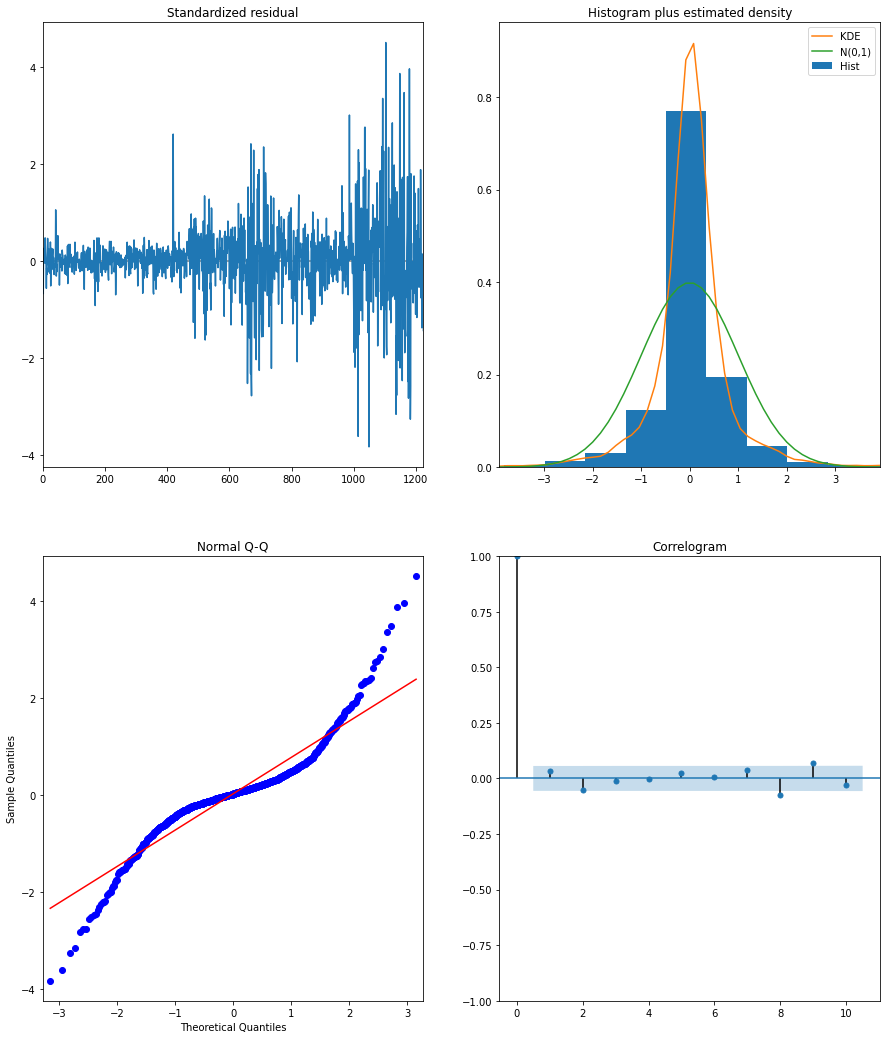

In [71]:
current_zip = 'Adj Close'
zip_params = output_df[output_df['zipcode']==current_zip]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(df_data[current_zip],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [72]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

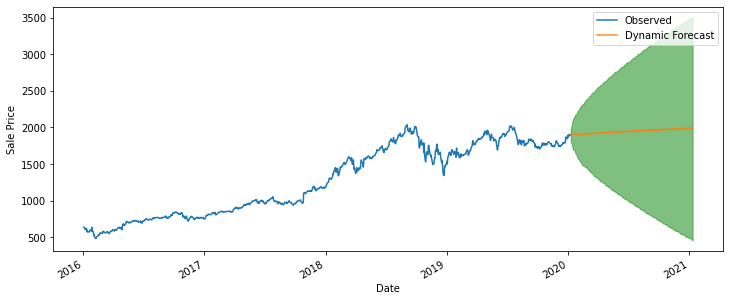

In [73]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[current_zip])
prediction_visual

In [74]:
# Get the real and predicted values
forecast_11238 = pred_dynamic.predicted_mean
truth_11238 = train[current_zip]#['1996':]

# Compute the mean square error
mse = ((forecast_11238 - truth_11238) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is nan
The Root Mean Squared Error of our forecasts is nan
